# Runs two PathSim simulations of the arc fuel cycle: 
# -1. TES as a single 3 meter high BCR.
# -2. TES as three 1m high BCRs in series.  

In [ ]:
import pathview
import json
from pathsim.blocks import Scope
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path

# Simulation time
sim_time = 300 * 24 * 3600

##### Single BCR model #####

# read graph data from a JSON file
with open("ARC_with_single_BCR.json", "r") as f:
    graph_data = json.load(f)

model1, duration = pathview.make_pathsim_model(graph_data)
print("Running ARC fuel cycle model with single BCR ...")

model1.run(sim_time)

# --- save simulation results for later plotting ---

save_dict = {}
for block in model1.blocks:
    if isinstance(block, Scope):
        try:
            sim_time, data = block.read()
        except Exception:
            # some blocks may not expose read() in all contexts
            continue
        # convert list-of-arrays to 2D array (ports x time)
        data_arr = np.array(data, dtype=object)
        labels = getattr(block, "labels", [f"port {i}" for i in range(data_arr.shape[0])])
        save_dict[f"{block.id}__time"] = np.array(sim_time)
        save_dict[f"{block.id}__data"] = data_arr
        save_dict[f"{block.id}__labels"] = np.array(labels, dtype=object)

out_file = Path("arc_single_BCR_results.npz")
if save_dict:
    np.savez_compressed(out_file, **save_dict)
    print(f"Saved simulation results to {out_file}")
else:
    print("No scope data saved.")


19:18:15 - INFO - LOGGING (log: True)
19:18:15 - INFO - BLOCKS (total: 39, dynamic: 10, static: 29, eventful: 1)
19:18:15 - INFO - GRAPH (nodes: 39, edges: 57, alg. depth: 6, loop depth: 0, runtime: 0.095ms)
19:18:15 - INFO - BLOCKS (total: 39, dynamic: 10, static: 29, eventful: 1)
19:18:15 - INFO - GRAPH (nodes: 39, edges: 57, alg. depth: 6, loop depth: 0, runtime: 0.095ms)
Running ARC fuel cycle model with single BCR ...
19:18:15 - INFO - STARTING -> TRANSIENT (Duration: 17280.00s)
Running ARC fuel cycle model with single BCR ...
19:18:15 - INFO - STARTING -> TRANSIENT (Duration: 17280.00s)
19:18:16 - INFO - --------------------   1% | 0.3s<8.8s | 22.5 it/s
19:18:16 - INFO - --------------------   1% | 0.3s<8.8s | 22.5 it/s
19:18:16 - INFO - ####----------------  20% | 1.0s<3.6s | 19.2 it/s
19:18:16 - INFO - ####----------------  20% | 1.0s<3.6s | 19.2 it/s
19:18:17 - INFO - #######-------------  35% | 2.1s<6.5s | 20.2 it/s
19:18:17 - INFO - #######-------------  35% | 2.1s<6.5s | 20

In [ ]:
sim_time = 300 * 24 * 3600

##### Series BCR model #####

# read graph data from a JSON file
with open("ARC_with_series_BCRs.json", "r") as f:
    graph_data = json.load(f)

model2, duration = pathview.make_pathsim_model(graph_data)

print("Running ARC fuel cycle model with series BCRs ...")

model2.run(sim_time)

# --- save simulation results for later plotting ---

save_dict = {}
for block in model2.blocks:
    if isinstance(block, Scope):
        try:
            sim_time, data = block.read()
        except Exception:
            # some blocks may not expose read() in all contexts
            continue
        # convert list-of-arrays to 2D array (ports x time)
        data_arr = np.array(data, dtype=object)
        labels = getattr(block, "labels", [f"port {i}" for i in range(data_arr.shape[0])])
        save_dict[f"{block.id}__time"] = np.array(sim_time)
        save_dict[f"{block.id}__data"] = data_arr
        save_dict[f"{block.id}__labels"] = np.array(labels, dtype=object)

out_file = Path("arc_series_BCRs_results.npz")
if save_dict:
    np.savez_compressed(out_file, **save_dict)
    print(f"Saved simulation results to {out_file}")
else:
    print("No scope data saved.")


19:18:22 - INFO - LOGGING (log: True)
19:18:22 - INFO - BLOCKS (total: 45, dynamic: 10, static: 35, eventful: 1)
19:18:22 - INFO - GRAPH (nodes: 45, edges: 77, alg. depth: 9, loop depth: 0, runtime: 0.102ms)
19:18:22 - INFO - BLOCKS (total: 45, dynamic: 10, static: 35, eventful: 1)
19:18:22 - INFO - GRAPH (nodes: 45, edges: 77, alg. depth: 9, loop depth: 0, runtime: 0.102ms)
Running ARC fuel cycle model with series BCRs ...
19:18:22 - INFO - STARTING -> TRANSIENT (Duration: 17280.00s)
Running ARC fuel cycle model with series BCRs ...
19:18:22 - INFO - STARTING -> TRANSIENT (Duration: 17280.00s)
19:18:23 - INFO - --------------------   1% | 0.5s<29.6s | 15.0 it/s
19:18:23 - INFO - --------------------   1% | 0.5s<29.6s | 15.0 it/s
19:18:24 - INFO - --------------------   4% | 1.5s<25.5s | 12.9 it/s
19:18:24 - INFO - --------------------   4% | 1.5s<25.5s | 12.9 it/s
19:18:25 - INFO - #-------------------   8% | 2.5s<21.6s | 15.7 it/s
19:18:25 - INFO - #-------------------   8% | 2.5s<21

## Generate Plots

Available scopes in model1 and their labels:
0: 15
    port 0: blanket (inv)
    port 1: HX (inv)
    port 2: FW (inv)
    port 3: Divertor (inv)
    port 4: T seperation membrane (inv)
1: 16
    port 0: storage (inv)
    port 1: pump (inv)
    port 2: fuel cleanup (inv)
    port 3: ISS (inv)
2: 50
    port 0: BCR 1 (eff)
3: 30
    port 0: fusion_reaction_rate
4: 51
    port 0: BCR 1 (y_T2_out)
    port 1: y_T2_in
5: 52
    port 0: BCR 1 (c_T_out)
    port 1: c_T_in [mol/m3]
Available scopes in model2 and their labels:
0: 30
    port 0: fusion_reaction_rate
1: 45
    port 0: BCR 1 (eff)
    port 1: BCR 2 (eff)
    port 2: BCR 3 (eff)
    port 3: Total efficiency
2: 46
    port 0: BCR 1 (c_T_out)
    port 1: c_T_in [mol/m3]
    port 2: BCR 2 (c_T_out)
    port 3: BCR 3 (c_T_out)
3: 49
    port 0: BCR 1 (y_T2_out)
    port 1: y_T2_in
    port 2: BCR 2 (y_T2_out)
    port 3: BCR 3 (y_T2_out)
4: 15
    port 0: blanket (inv)
    port 1: HX (inv)
    port 2: FW (inv)
    port 3: Divertor (in

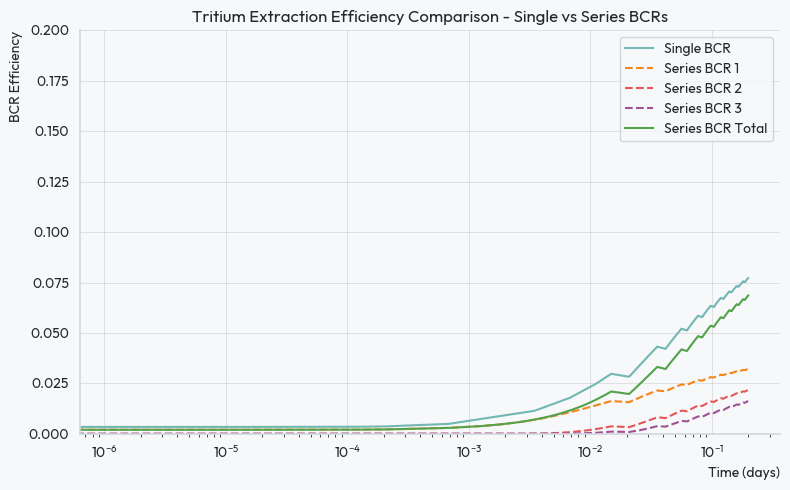

In [12]:
import morethemes as mt
import numpy as np

mt.set_theme("lighter")

# gather scopes from the single BCR model (model1) to match the plotting intent
scopes1 = [block for block in model1.blocks if isinstance(block, Scope)]

print("Available scopes in model1 and their labels:")
for i, scope in enumerate(scopes1):
    labels = getattr(scope, 'labels', None)
    print(f"{i}: {scope.id}")
    if labels:
        for j, lb in enumerate(labels):
            print(f"    port {j}: {lb}")
    else:
        print("    (no labels)")
        
# gather scopes from the series BCR model (model2) to match the plotting intent
scopes2 = [block for block in model2.blocks if isinstance(block, Scope)]

print("Available scopes in model2 and their labels:")
for i, scope in enumerate(scopes2):
    labels = getattr(scope, 'labels', None)
    print(f"{i}: {scope.id}")
    if labels:
        for j, lb in enumerate(labels):
            print(f"    port {j}: {lb}")
    else:
        print("    (no labels)")

# load saved single & series BCR models results
from pathlib import Path
single_BCR_results_file = Path("arc_single_BCR_results.npz")
series_BCR_results_file = Path("arc_series_BCRs_results.npz")

saved_single = None
if single_BCR_results_file.exists():
    saved_single = np.load(single_BCR_results_file, allow_pickle=True)
    print(f"Loaded saved results from {single_BCR_results_file}")
else:
    print(f"Saved results not found at {single_BCR_results_file}; will use live scope.read() as fallback.")

saved_series = None
if series_BCR_results_file.exists():
    saved_series = np.load(series_BCR_results_file, allow_pickle=True)
    print(f"Loaded saved results from {series_BCR_results_file}")
else:
    print(f"Saved results not found at {series_BCR_results_file}; will use live scope.read() as fallback.")


def get_saved(scope, saved):
    """Return (sim_time, data_list) for a given scope using saved file when available.
    data_list is a list where each entry corresponds to a port time-series (1D array).
    """
    if saved is None:
        return scope.read()
    tid = f"{scope.id}__time"
    did = f"{scope.id}__data"
    lid = f"{scope.id}__labels"
    if tid in saved and did in saved:
        sim_time = np.array(saved[tid])
        data_arr = saved[did]  # object array: ports x times
        # turn into list-of-1d-arrays for compatibility with existing plotting code
        data_list = [np.array(row) for row in data_arr]
        return sim_time, data_list
    else:
        return scope.read()


# Efficiency data is in scope index 3 (adjust if different)
single_BCR_sim_time, single_BCR_efficiency = get_saved(scopes1[2], saved_single)

series_BCR_sim_time, series_BCR_efficiencies = get_saved(scopes2[1], saved_series)  # --- IGNORE ---


# ensure time is 1D
single_BCR_time = np.ravel(single_BCR_sim_time) if single_BCR_sim_time is not None else np.array([])
series_BCR_time = np.ravel(series_BCR_sim_time) if series_BCR_sim_time is not None else np.array([])

# convert seconds -> days
single_BCR_time_days = single_BCR_time / 3600.0 / 24.0 if single_BCR_time.size else single_BCR_time
series_BCR_time_days = series_BCR_time / 3600.0 / 24.0 if series_BCR_time.size else series_BCR_time

single_BCR_efficiency = np.ravel(np.array(single_BCR_efficiency[0]))

series_BCR_1_efficiency = np.ravel(np.array(series_BCR_efficiencies[0]))
series_BCR_2_efficiency = np.ravel(np.array(series_BCR_efficiencies[1]))
series_BCR_3_efficiency = np.ravel(np.array(series_BCR_efficiencies[2]))
series_BCR_total_efficiency = np.ravel(np.array(series_BCR_efficiencies[3]))


fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(1, 1, 1)
ax.plot(single_BCR_time_days, single_BCR_efficiency, label="Single BCR", ls = '-')
ax.plot(series_BCR_time_days, series_BCR_1_efficiency, label="Series BCR 1", ls = '--')
ax.plot(series_BCR_time_days, series_BCR_2_efficiency, label="Series BCR 2", ls = '--')
ax.plot(series_BCR_time_days, series_BCR_3_efficiency, label="Series BCR 3", ls = '--')
ax.plot(series_BCR_time_days, series_BCR_total_efficiency, label="Series BCR Total", ls = '-')
ax.set_xlabel("Time (days)")
ax.set_ylabel("BCR Efficiency")
ax.set_xscale("log")
ax.set_ylim(0,0.2)
ax.legend(loc = 'best')
ax.set_title("Tritium Extraction Efficiency Comparison - Single vs Series BCRs")
fig.tight_layout()
plt.show()